## Analysis of Translation Efficiencies

### 1 Data import

In [1]:
import cPickle as pkl
import collections as col
import pandas as pd
import numpy as np
import matplotlib

matplotlib.use("pgf")
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [u'Adobe Caslon Pro'],                   # use latex default serif font
    "font.sans-serif": ["Consolas"], # use a specific sans-serif font
}
matplotlib.rcParams.update(pgf_with_rc_fonts)

import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.style.use('ggplot')
matplotlib.style.use('bmh')
from statsmodels.nonparametric.smoothers_lowess import lowess

To update the TEs, run https://github.com/gittenberg/TRSL/blob/master/workbooks/analyses/TRSL_time-resolved_single-gene_analyses.ipynb first.

In [2]:
time_tes = pkl.load(open("../../parameters/te_time-resolved.p"))
init_rates = pkl.load(open("../../parameters/init_rates_plotkin.p"))

In [3]:
annotations = pd.DataFrame.from_csv('../../data/sce_Nagaraj.tsv', sep='\t', header=1)

How many can we work with:

In [4]:
print time_tes.shape
print len(init_rates.keys())
print len(annotations.index)
print len(time_tes.transpose().to_dict().viewkeys() & init_rates.viewkeys())

(5581, 12)
4839
3794
4606


### 2 Translation efficiencies vs initiation rates over the cycle

In [5]:
def scatter_dicts(dict1, dict2, lowess=True, logaxis=True, xaxislabel=None, yaxislabel=None, fontsize=None, alpha=0.2):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    if logaxis:
        ax.set_xscale('log')
        ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
    if fontsize:
        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys)
    scat.set_alpha(alpha)

    if lowess:
        points = zip(xs, ys)
        sorted_points = sorted(points)
        new_xs = [point[0] for point in sorted_points]
        new_ys = [point[1] for point in sorted_points]
        ylowess = lowess(new_ys, new_xs)[:,1]
        plt.plot(new_xs, ylowess, 'orange', linewidth=4)

In [6]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

4606


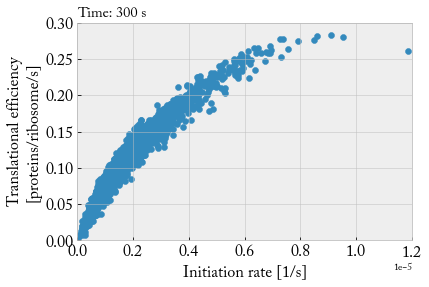

4606


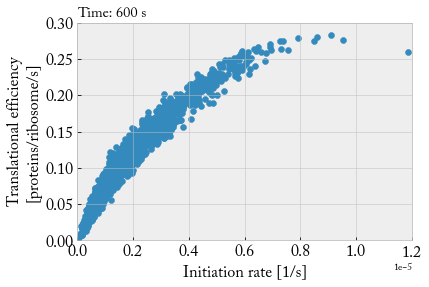

4606


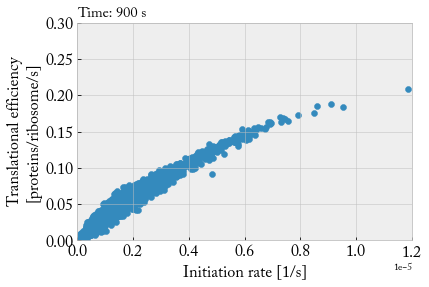

4606


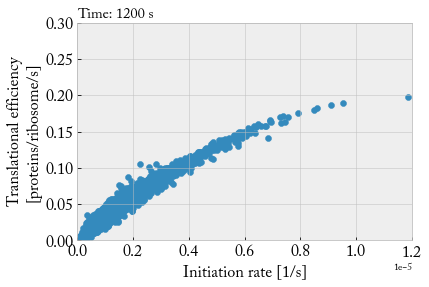

4606


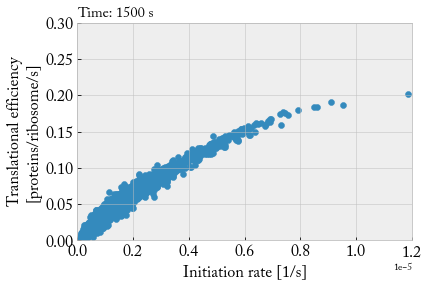

4606


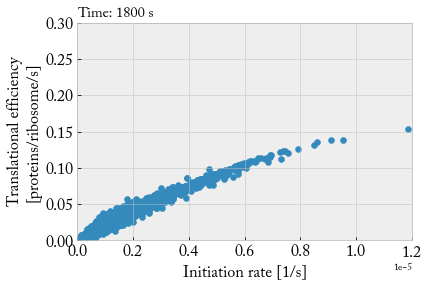

4606


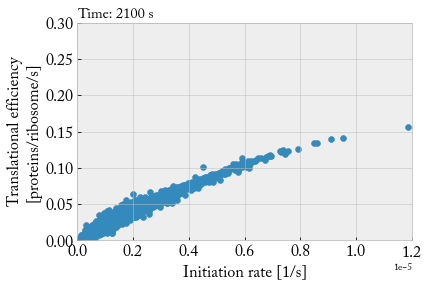

4606


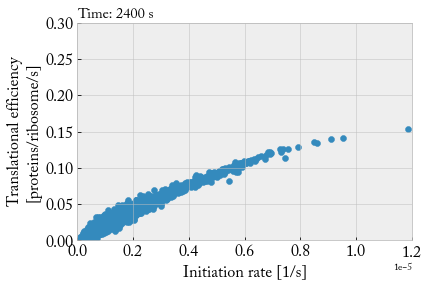

4606


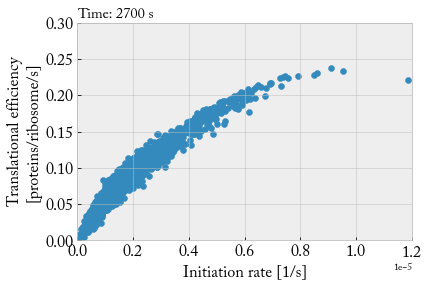

4606


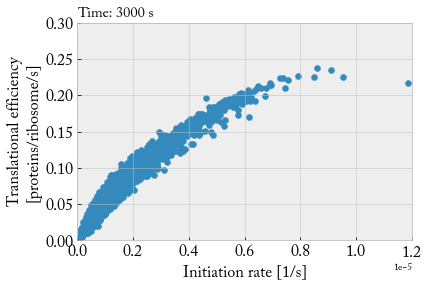

4606


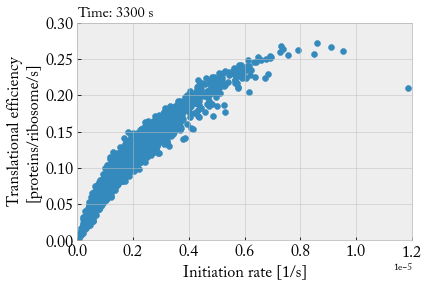

4606


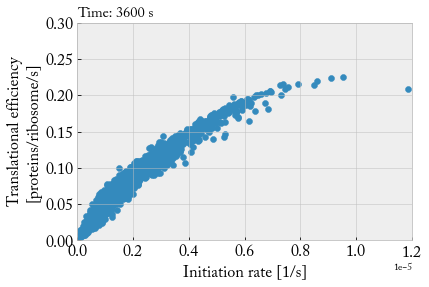

In [7]:
for time in time_tes.columns:
    scatter_dicts(init_rates, time_tes[time].to_dict(), logaxis=False, lowess=False, xaxislabel='Initiation rate [1/s]', 
                  yaxislabel='Translational efficiency\n[proteins/ribosome/s]', fontsize=16, alpha=1.0)
    plt.title('Time: {} s'.format(time+300), loc='left')
    plt.xlim([1e-8, 1.2e-5])
    plt.ylim([0.0, 0.3])
    plt.locator_params(axis='x',nbins=10)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.show()

### 3 Same but with annotation and color

In [8]:
annotations = pkl.load(open("../../parameters/annotations_liebermeister.p", "rb"))
annotations = {k: v for k, v in annotations.items() if v}  # remove empty values
functional_categories = col.Counter(annotations.values())
functional_categories = col.Counter({k: v for k, v in functional_categories.items() if v >= 50})  # minimum count
annotations = {k: v for k, v in annotations.items() if v in functional_categories}

In [9]:
plotkeys = init_rates.viewkeys() & time_tes.transpose().to_dict().viewkeys() & annotations.viewkeys() # intersection
print len(plotkeys)

724


In [10]:
import matplotlib.cm as cm
colormap = cm.Set1(np.linspace(0, 1, len(functional_categories.most_common())))
colordict = {j[0]: colormap[i] for i, j in enumerate(functional_categories.most_common())}

In [11]:
colors = [colordict[annotations[key]] for key in plotkeys]

We create several series and scatter on top of each other.

In [12]:
time_tes_by_function = {}

time = 300

init_rates_by_function = {}
time_tes_by_function[time] = {}

for function in functional_categories.keys():
    init_rates_by_function[function] = [init_rates[key] for key in plotkeys if annotations[key]==function]
    time_tes_by_function[time][function] = [time_tes[time].to_dict()[key] for key in plotkeys 
                                            if annotations[key]==function]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

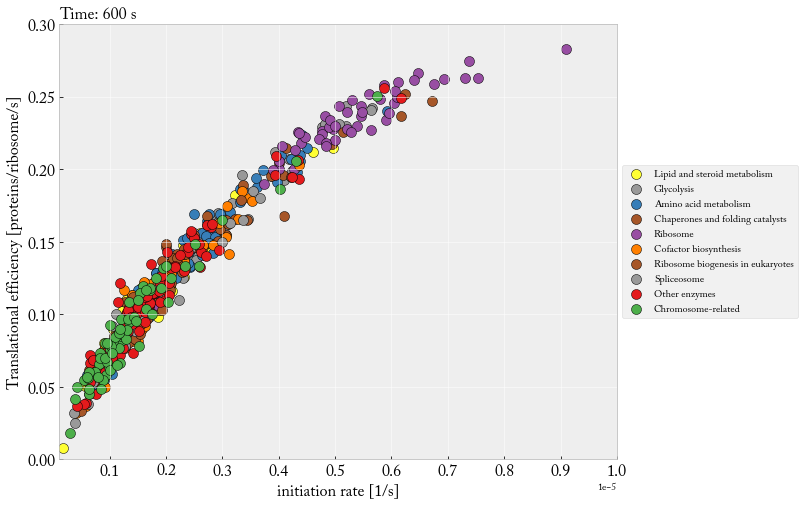

In [13]:
plt.rcParams['figure.figsize'] = (10, 8)

fontsize = 16
xaxislabel = 'initiation rate [1/s]'
yaxislabel = 'Translational efficiency [proteins/ribosome/s]'

fig =  plt.figure()                

ax = fig.add_subplot(111)
ax.grid(True, linestyle = '-', color = '1.0')

for function in functional_categories.keys():
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], c=colordict[function], 
                       label=function, s=100, edgecolor='black')
    scat.set_alpha(1.0)
    
plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)


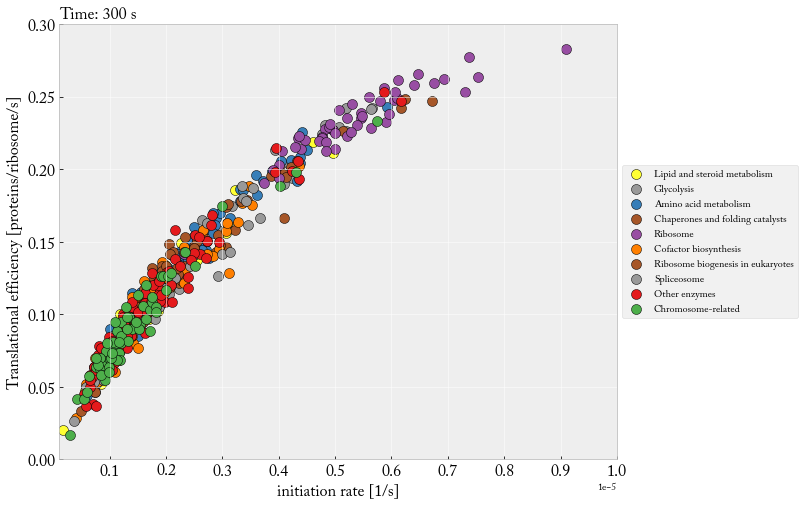

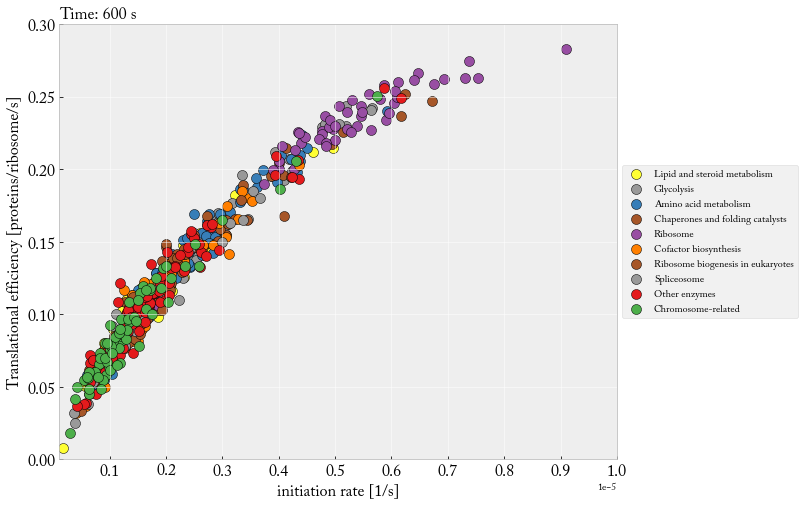

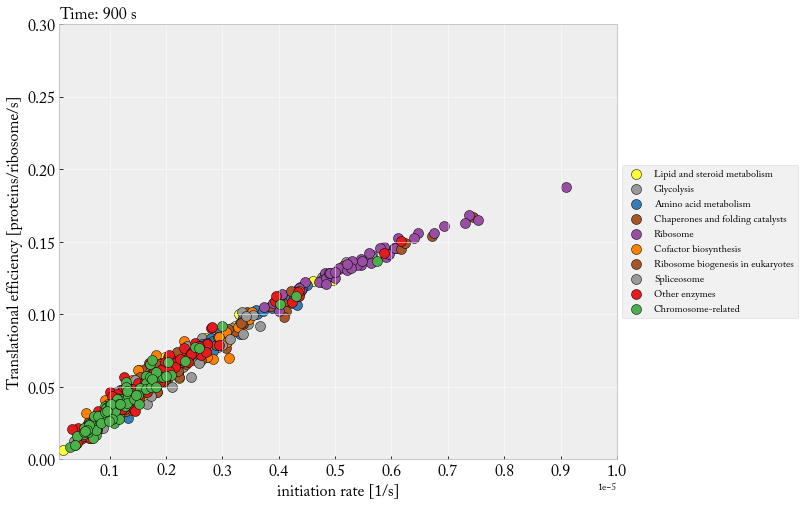

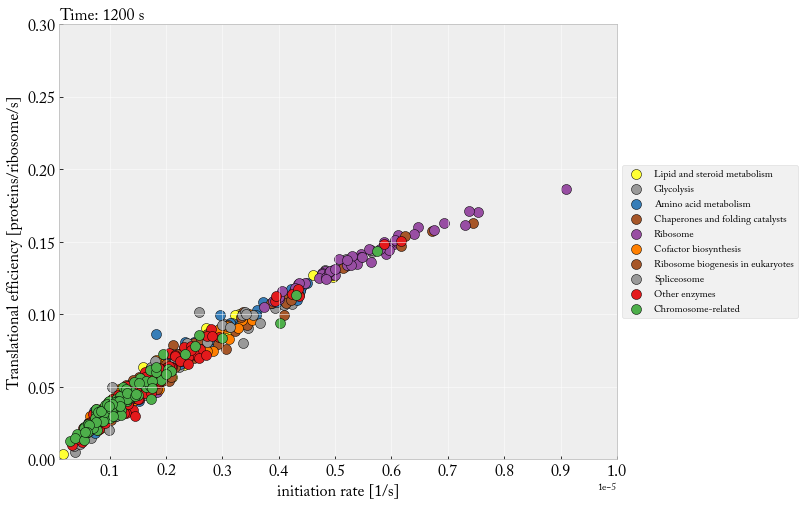

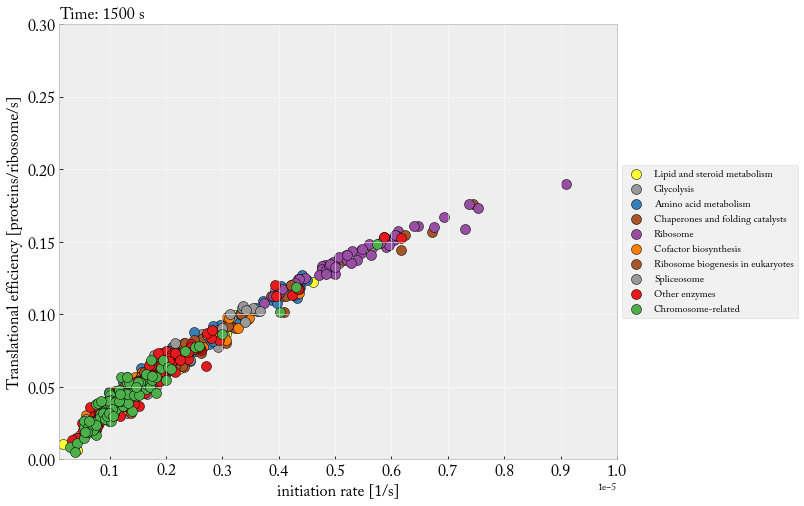

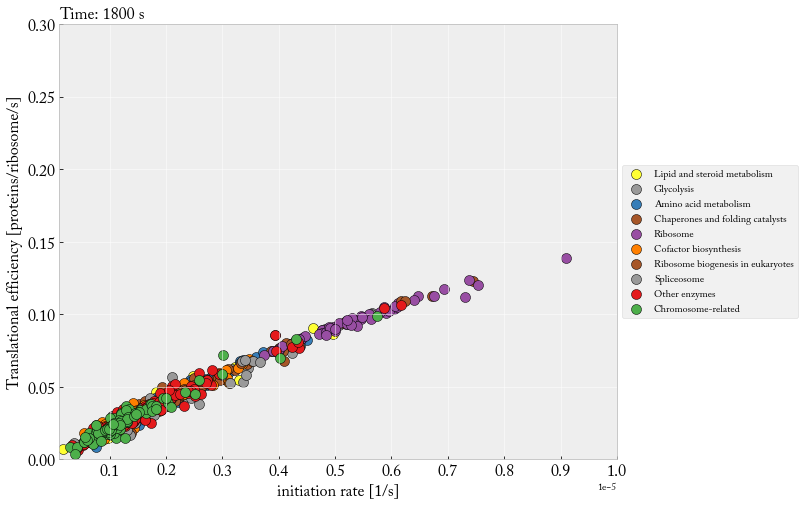

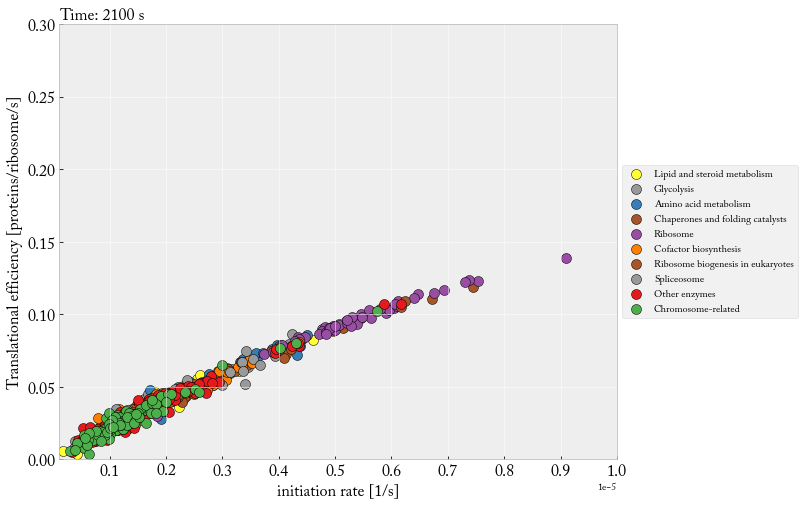

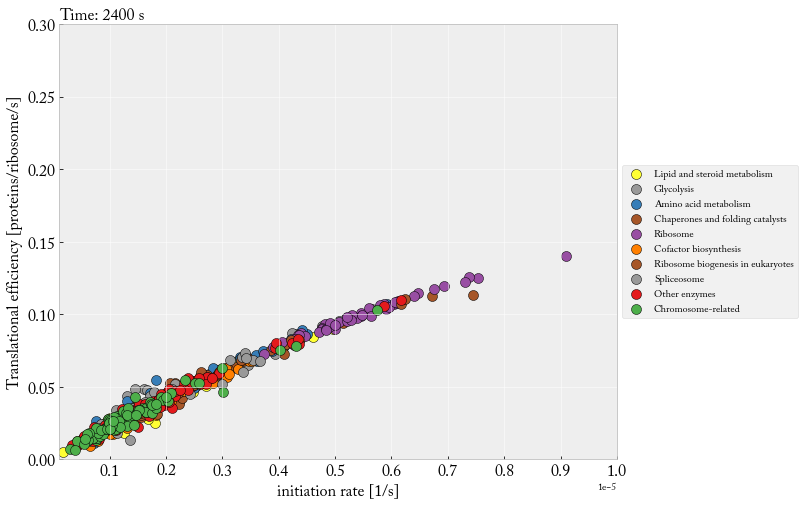

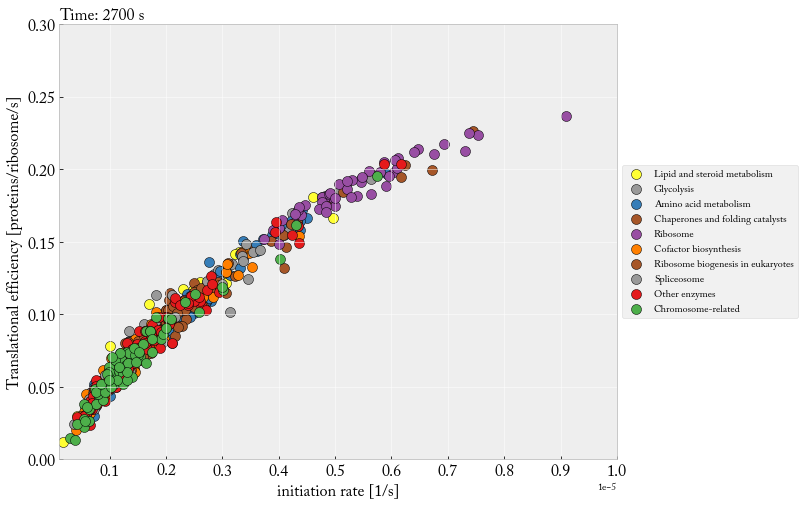

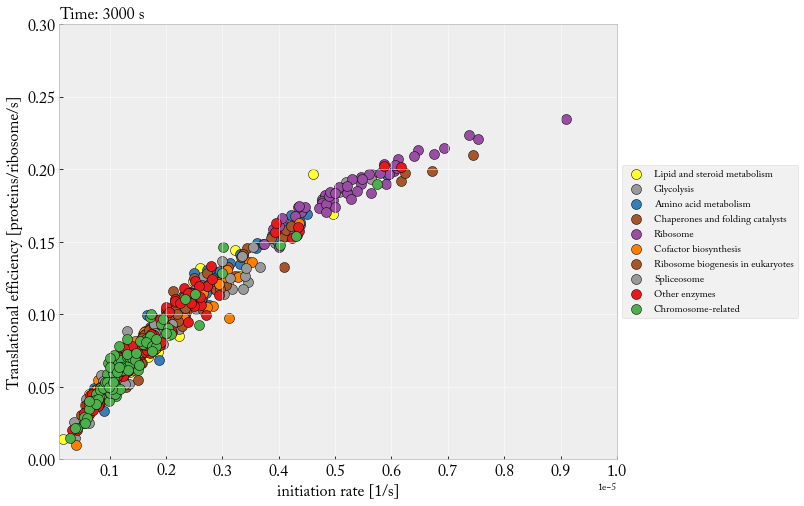

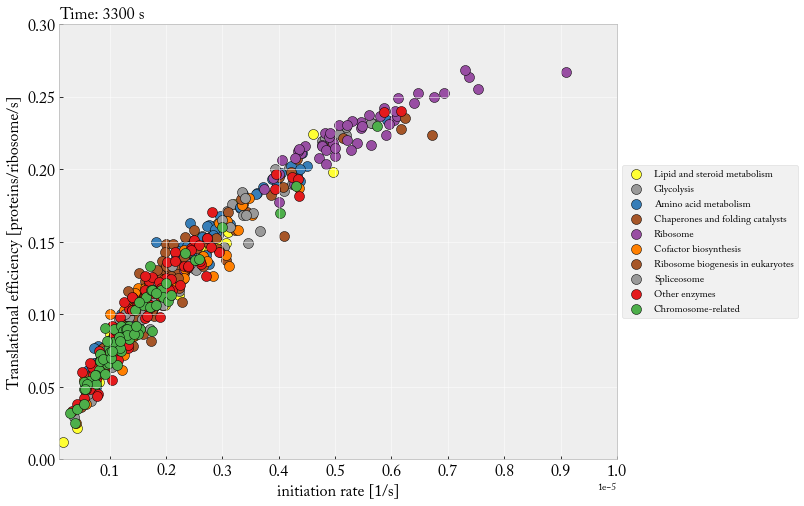

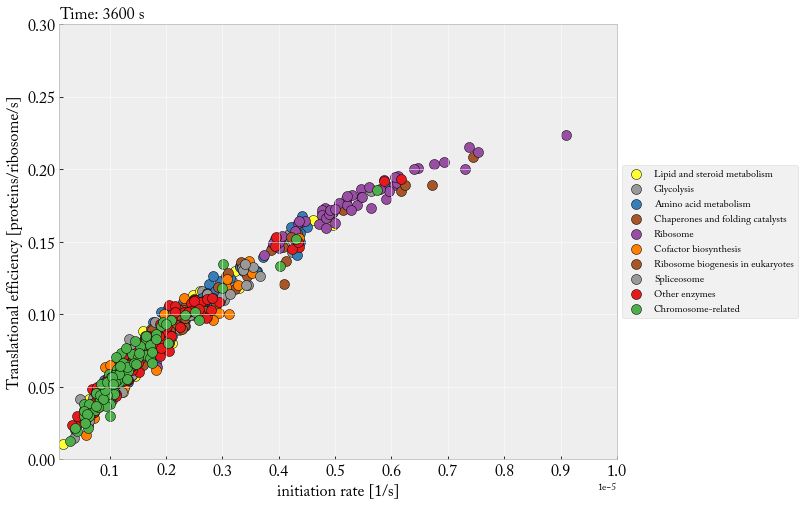

In [14]:
time_tes_by_function = {}
init_rates_by_function = {}

for time in time_tes.columns:
    time_tes_by_function[time] = {}

    for function in functional_categories.keys():
        init_rates_by_function[function] = [init_rates[key] for key in plotkeys if annotations[key]==function]
        time_tes_by_function[time][function] = [time_tes[time].to_dict()[key] for key in plotkeys 
                                                if annotations[key]==function]
    fontsize = 16

    xaxislabel = 'initiation rate [1/s]'
    yaxislabel = 'Translational efficiency [proteins/ribosome/s]'

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '1.0')

    for function in functional_categories.keys():
        scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], c=colordict[function], 
                           label=function, s=100, edgecolor='black')
        scat.set_alpha(1.0)

    plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
    plt.xlim([1e-7, 1.0e-5])
    plt.ylim([0.0, 0.3])
    plt.locator_params(axis='x',nbins=10)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_xlabel(xaxislabel)
    ax.set_xlabel(xaxislabel, fontsize=fontsize)
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    ax.set_ylabel(yaxislabel)
    ax.set_ylabel(yaxislabel, fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)

### Plot against time axis

Let's do it right this time.

In [15]:
annotations_df = pd.DataFrame.from_dict(annotations, orient='index', dtype=None)
annotations_df.columns = ["Function"]

In [16]:
time_tes_annotated = pd.merge(time_tes, annotations_df, how='inner', on=None, left_on=None, right_on=None,
                              left_index=True, right_index=True, sort=True, copy=True, indicator=False)

http://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot

In [17]:
def rand_jitter(arr):
    stdev = .0125 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, 
           linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, 
                       vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, hold=hold, **kwargs)

/home/martin/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


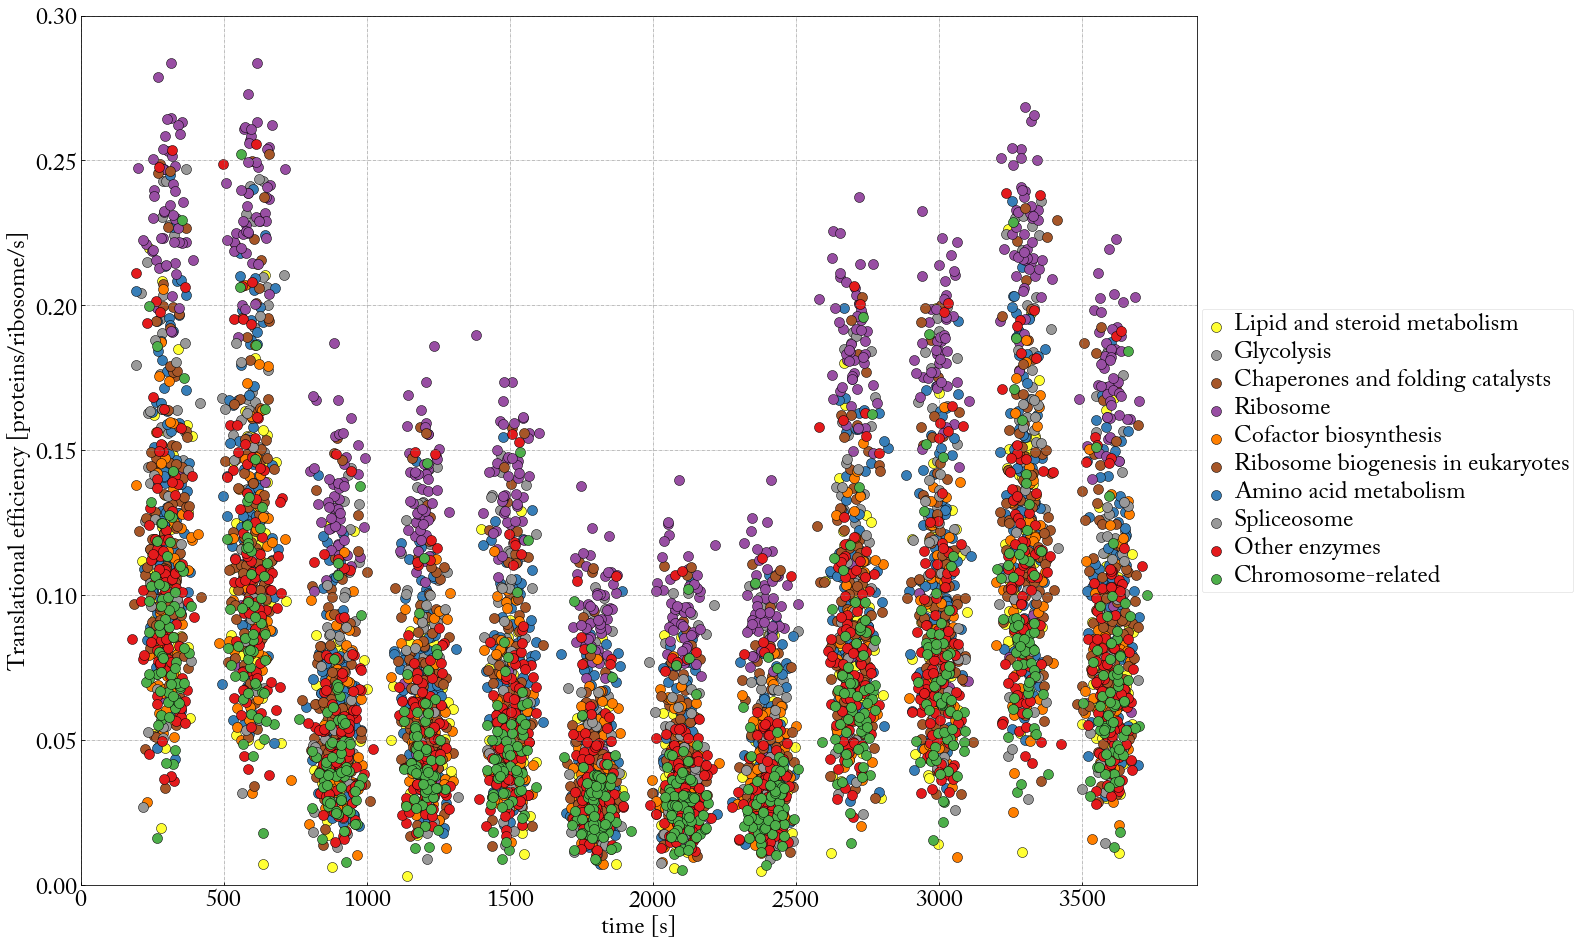

In [19]:
plt.rc('font',family=u'Adobe Caslon Pro')
plt.rcParams['figure.figsize'] = (20, 16)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.labelcolor']='black'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['grid.linestyle']='-.'
plt.rcParams['grid.color']='grey'
#plt.rcParams['figure.facecolor'] = 'white'

hfont = {'fontname': u'Adobe Caslon Pro'}

fig =  plt.figure()                

ax = fig.add_subplot(111, axisbg='white')

fontsize = 24

xaxislabel = 'time [s]'
yaxislabel = 'Translational efficiency [proteins/ribosome/s]'

#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([0, 3900])
plt.ylim([0.0, 0.3])
#plt.locator_params(axis='x',nbins=10)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlabel(xaxislabel, **hfont)
ax.set_xlabel(xaxislabel, fontsize=fontsize, **hfont)
plt.setp(ax.get_xticklabels(), fontsize=fontsize, **hfont)
#ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize, **hfont)
plt.setp(ax.get_yticklabels(), fontsize=fontsize, **hfont)

for function in functional_categories.keys():
    df = time_tes_annotated[time_tes_annotated['Function']==function]
    del df['Function']
    df = df[df!=0]  # not sure why but after updating there were many zero values. I remove them manually
    df = df.transpose()
    for i, gene in enumerate(df.columns):
        scat = jitter(df.index+300, df[gene], c=colordict[function], label=function, s=100, edgecolor='black')
        scat.set_alpha(1.0)      

handles, labels = ax.get_legend_handles_labels()
#print handles
#print labels

shortlabels = list(set(labels))

plt.legend(labels=shortlabels, loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, facecolor="white")

legend = ax.get_legend()

for i, label in enumerate(shortlabels):
    legend.legendHandles[i].set_color(colordict[label])
    legend.legendHandles[i].set_edgecolor('black')

for label in legend.get_texts():
    label.set_fontsize(fontsize)
    
#plt.savefig("functional_time_resolved.pgf", bbox_inches='tight')
plt.show()

### Combined in one plot

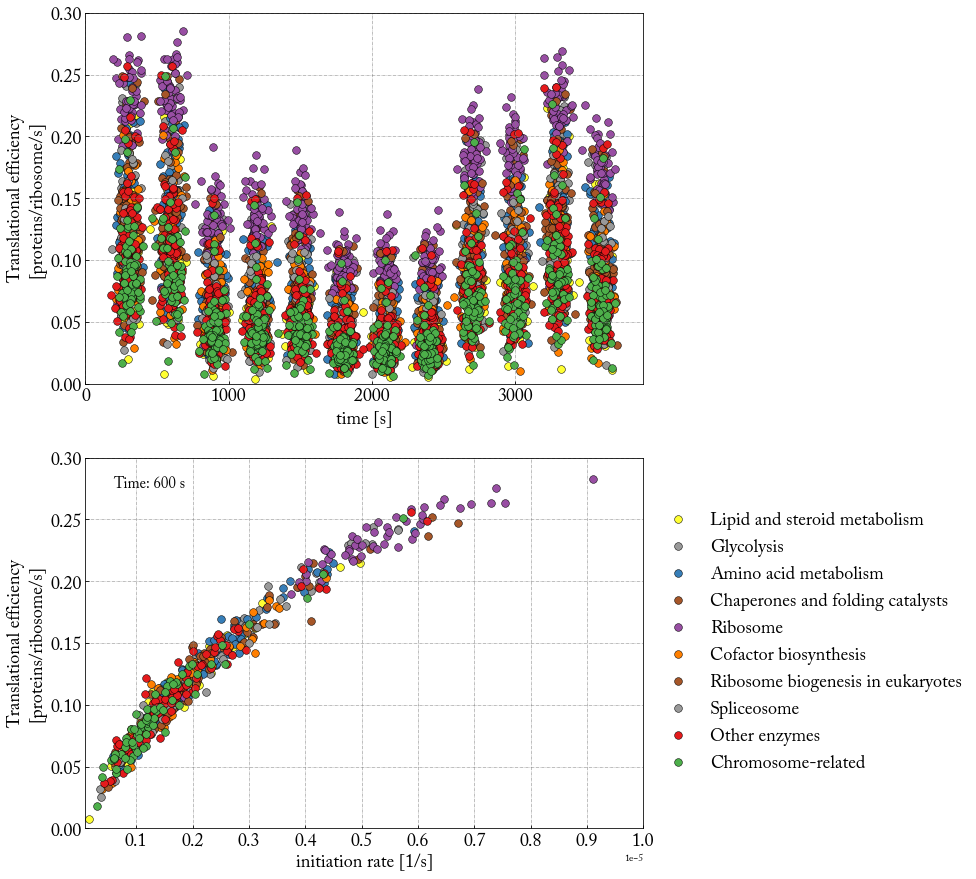

In [20]:
plt.rcParams['figure.figsize'] = (10, 15)

fig =  plt.figure()                

ax = fig.add_subplot(211, axisbg='white')

fontsize = 18
markersize = 60

xaxislabel = 'time [s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([0, 3900])
plt.ylim([0.0, 0.3])
#plt.locator_params(axis='x',nbins=10)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

for function in functional_categories.keys():
    df = time_tes_annotated[time_tes_annotated['Function']==function]
    del df['Function']
    df = df[df!=0]  # not sure why but after updating there were many zero values. I remove them manually
    df = df.transpose()
    for i, gene in enumerate(df.columns):
        scat = jitter(df.index+300, df[gene], c=colordict[function], label=function, s=markersize, edgecolor='black',
                     rasterized=True)
        scat.set_alpha(1.0)      

handles, labels = ax.get_legend_handles_labels()
#print handles
#print labels

shortlabels = list(set(labels))

#plt.text(-350, 0.3, "A", fontsize=24, weight="bold")

ax = fig.add_subplot(212, axisbg='white')

time = 300
#fontsize = 24
xaxislabel = 'initiation rate [1/s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

for function in functional_categories.keys():
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], c=colordict[function], 
                       label=function, s=markersize, edgecolor='black', rasterized=True)
    scat.set_alpha(1.0)
    
#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
ax.text(.05, .92, 'Time: 600 s', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), fontsize=fontsize)
plt.rc('font', **{'size':'24'})

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('time_and_init_rate_resolved_efficiency.png', bbox_inches='tight', dpi=400)
#plt.show()

#### Separate plots

Trick to make labels unique: https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib

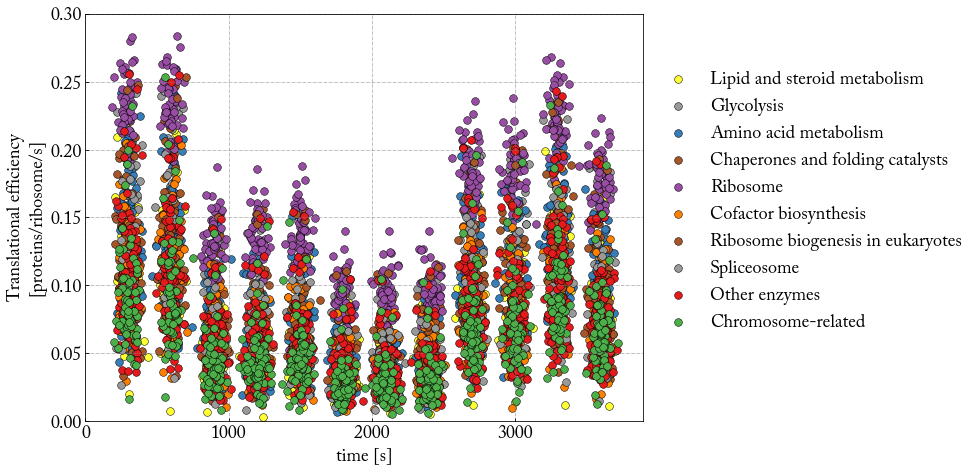

In [29]:
plt.rcParams['figure.figsize'] = (10, 7.5)

fig =  plt.figure()                

ax = fig.add_subplot(111, axisbg='white')

fontsize = 18
markersize = 60

xaxislabel = 'time [s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([0, 3900])
plt.ylim([0.0, 0.3])
#plt.locator_params(axis='x',nbins=10)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

for function in functional_categories.keys():
    df = time_tes_annotated[time_tes_annotated['Function']==function]
    del df['Function']
    df = df[df!=0]  # not sure why but after updating there were many zero values. I remove them manually
    df = df.transpose()
    for i, gene in enumerate(df.columns):
        scat = jitter(df.index+300, df[gene], c=colordict[function], label=function if i == 0 else "", 
                      s=markersize, edgecolor='black', rasterized=True)
        scat.set_alpha(1.0)      

handles, labels = ax.get_legend_handles_labels()
#print handles
#print labels

#labels = list(set(labels))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')


#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('time_resolved_efficiency.png', bbox_inches='tight', dpi=400)
#plt.show()

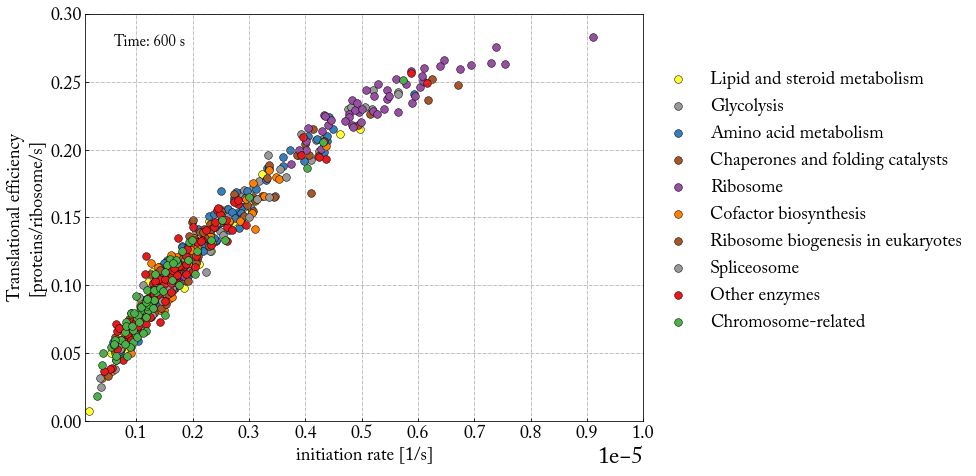

In [28]:
plt.rcParams['figure.figsize'] = (10, 7.5)

fig =  plt.figure()                

ax = fig.add_subplot(111, axisbg='white')

fontsize = 18
markersize = 60

time = 300
#fontsize = 24
xaxislabel = 'initiation rate [1/s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

for function in functional_categories.keys():
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], c=colordict[function], 
                       label=function, s=markersize, edgecolor='black', rasterized=True)
    scat.set_alpha(1.0)
    
#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
ax.text(.05, .92, 'Time: 600 s', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), fontsize=fontsize)
plt.rc('font', **{'size':'24'})

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('efficiency_by_function_and_init_rate.pgf', bbox_inches='tight', dpi=400)
#plt.show()